In [181]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as xccrs
import cartopy.feature as cfeature
import xesmf as xe
%matplotlib inline

import momlevel

import matplotlib.ticker as mticker
panellabs=list(map(chr, range(97, 123)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Bring in and filter TG data generated from import_rlr_matlab notebook, which calls the readRLRmonthly.m script

In [182]:
df_ids = pd.read_csv('PSMSL_ids2.csv')
df_ids=df_ids.T
df_ids.index.names = ["name"]
df_ids.rename(columns={0: 'lat', 1: 'lon', 2: 'name2', 3: 'coast'}, inplace = True)
df_ids['coast']=df_ids['coast'].str.zfill(3)
df_ids.lat=df_ids.lat.astype(float)
df_ids.lon=df_ids.lon.astype(float)
df_ids=df_ids.sort_values(['coast','lat'],axis=0,ascending=[True,True])

In [183]:
df = pd.read_csv('PSMSL_data.csv')
df.columns,df_ids.columns
df.rename(columns = {'0':'datetime'}, inplace = True)
df['datetime']=pd.to_datetime(df.datetime-719529,unit='d').round('s')
df_ts=df
df_ts.set_index('datetime', inplace=True)
df_ts=df_ts.loc['1993-01-01':'2018-12-31']
df_ts=(df_ts-df_ts.mean(axis=0))/10

In [184]:
#mask by psmsl ids: small subset for testing
# mask=df_ids.index.isin(['10','234','12','235'])

In [185]:
df_ids=df_ids.reset_index()
df_ts = df_ts[df_ids.name]

In [187]:
# mask by missing values, delete other mask if using
missingmonths = df_ts.isna().sum()
fraccomplete = 1-(missingmonths/len(df_ts))
mask0 = missingmonths<12
mask=mask0

In [188]:
tg_ts_filt = df_ts.loc[:,mask]
tgs_in=df_ids
tgs_in.index=tgs_in.name
tgs_in=tgs_in[mask]

In [189]:
tgnames=tgs_in['name2'].str.replace(r"\(.*\)","")
tgnames=tgnames.str.replace(r"\,.*","")
tgnames=tgnames.str.replace(r"\-.*","")
tgnames=tgnames.str.replace(r"\/.*","")
tgnames=tgnames.str.title()

/glade/scratch/clittle/ipykernel_200979/1520746464.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tgnames=tgs_in['name2'].str.replace(r"\(.*\)","")
/glade/scratch/clittle/ipykernel_200979/1520746464.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tgnames=tgnames.str.replace(r"\,.*","")
/glade/scratch/clittle/ipykernel_200979/1520746464.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tgnames=tgnames.str.replace(r"\-.*","")
/glade/scratch/clittle/ipykernel_200979/1520746464.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  tgnames=tgnames.str.replace(r"\/.*","")


In [190]:
tgnames

name
638             Reykjavik
1421                   Ny
642              Kigiliah
641             Kotelnyi 
302                Tregde
              ...        
393            St. John'S
1597             Rimouski
1322                 Sept
447             Churchill
913     Argentine Islands
Name: name2, Length: 365, dtype: object

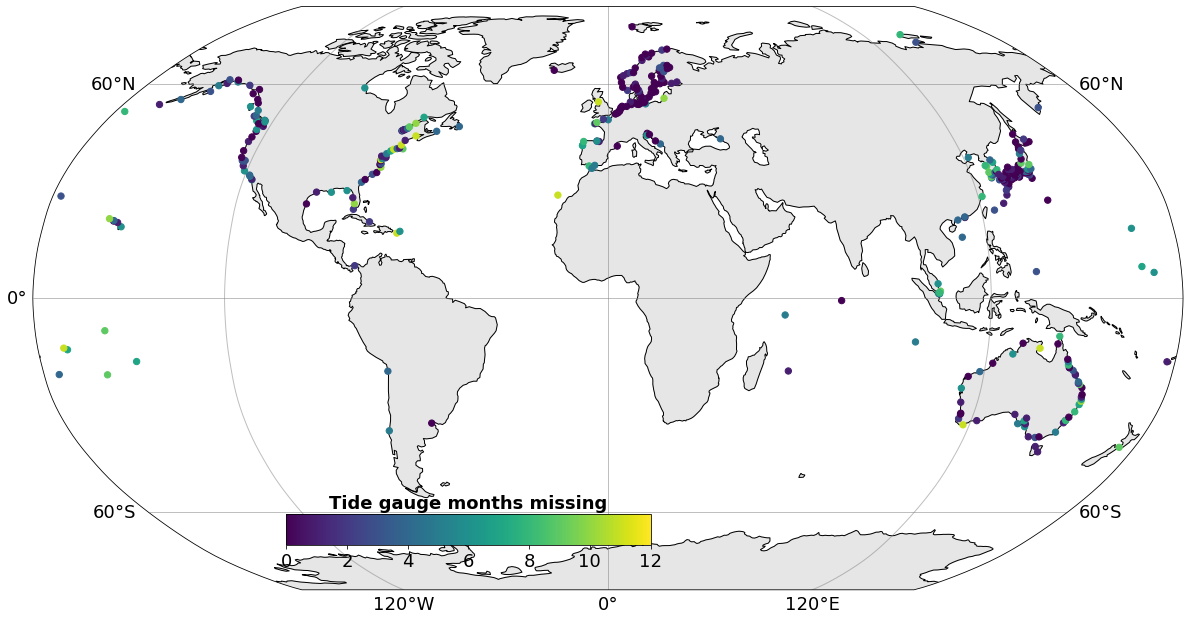

In [191]:
fig = plt.figure(figsize=(22,22))#, tight_layout=True)


# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 0
plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.16
yshift=.028
cb_w=.23
cb_h=.02
cmap='viridis'

# cmap=parula_map

z= tg_ts_filt.isna().sum()
w=-75; e=-75; s=21; n=48;

vmin=0
vmax=12

ax = fig.add_subplot(2,1,1, projection=xccrs.Robinson())
ax.set_global()
pos = ax.get_position() # get the original position 


# ax.set_extent([-160,160,-70,75])

ax.add_feature(cfeature.LAND.with_scale('110m'),color='.9')
ax.coastlines()
gl = ax.gridlines(crs=xccrs.PlateCarree(), draw_labels=True, 
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')    
gl.left_labels = True
gl.right_labels = False 
gl.top_labels = False 
gl.bottom_labels = True
XTEXT_SIZE = 18
YTEXT_SIZE = XTEXT_SIZE
# to facilitate text rotation at bottom edge, ...
# text justification: 'ha':'right' is used to avoid clashing with map's boundary
# default of 'ha' is center, often causes trouble when text rotation is not zero
gl.xlabel_style = {'size': XTEXT_SIZE, 'color': 'k', 'rotation':0, 'ha':'center'}
gl.ylabel_style = {'size':YTEXT_SIZE, 'color': 'k', 'weight': 'normal'}
gl.xlocator = mticker.FixedLocator([-120,0,120])
gl.ylocator = mticker.FixedLocator([-60,0,60])

filled=plt.scatter(x=tgs_in.lon, y=tgs_in.lat, vmin=vmin, vmax=vmax,
        c=z, cmap=cmap,  #this is the changes            
        s=40,
        alpha=1,
        edgecolors= None,
        linewidth=1,            
        marker=None,
        zorder=3,
        transform=xccrs.PlateCarree()) ## Important
# ax1 = plt.subplot2grid((2,5), (1, 1), colspan=1, rowspan=1)
# ax1.plot(z,np.arange(0.5,len(tgnames),1))
# # plt.ylim([0,len(tgnames)])
# plt.yticks(np.arange(0.5,len(tgnames),1), tgnames,
#        rotation=0) 
# plt.grid()
# # plt.xticks(np.arange(0.5,len(tg_ts_filt),xlabspacing), tg_ts_filt.index.year[np.arange(0,len(tg_ts_filt),xlabspacing)])

cbar_ax = fig.add_axes([pos.x0+xshift, pos.y0+yshift, cb_w,cb_h])
cbar=fig.colorbar(filled,orientation='horizontal', cax=cbar_ax)
cbar.ax.set_title('Tide gauge months missing', rotation=0,size=18,weight='bold')
cbar.ax.tick_params(labelsize=18)

In [192]:
# tgs_in=tg_ids_filt.T
# tgs_in.lat=tgs_in.lat.astype(float)
# tgs_in.lon=tgs_in.lon.astype(float)
# pd.set_option('display.max_rows', 10)
# tgs_in.reset_index()
tg_ts_filt

,638,1421,642,641,302,47,1113,1759,33,62,...,201,951,192,999,1244,393,1597,1322,447,913
datetime,,,,,,,,,,,,,,,,,,,,,
1993-01-15,8.279808,37.530128,11.841424,13.980263,12.675484,20.196795,28.73109,33.4,38.057372,40.149839,...,-5.721154,-20.409677,-12.598071,-14.318182,-16.026403,-2.331169,NaN,-16.101639,0.48366,-7.348065
1993-02-15,-18.820192,16.230128,0.841424,-1.019737,-11.124516,-13.103205,-6.56891,-5.6,-4.342628,-3.450161,...,5.278846,-4.409677,0.401929,-0.318182,-12.026403,-8.331169,-11.811258,-12.101639,-8.51634,-6.048065
1993-03-15,-12.120192,5.130128,9.841424,6.980263,-12.324516,-12.203205,-8.86891,-8.2,-8.042628,-7.250161,...,13.278846,2.590323,3.401929,-4.318182,-16.026403,-12.331169,-11.811258,-14.101639,-20.51634,-1.448065
1993-04-15,-14.420192,-1.969872,-21.158576,-25.019737,-11.824516,-12.803205,-13.26891,-13.1,-15.342628,-15.550161,...,121.278846,77.590323,63.401929,24.681818,-0.026403,-14.331169,3.188742,-5.101639,-19.51634,2.551935
1993-05-15,-23.120192,-7.769872,-14.158576,-40.019737,-9.924516,-11.403205,-10.86891,-11.5,-12.942628,-12.750161,...,56.278846,38.590323,31.401929,14.681818,-5.026403,-11.331169,5.188742,1.898361,6.48366,5.851935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-15,9.879808,-4.369872,13.841424,7.980263,0.175484,0.596795,1.53109,2.2,3.857372,4.649839,...,-15.721154,-9.409677,-8.598071,-5.318182,-1.026403,-3.331169,-0.811258,-6.101639,-2.51634,1.051935
2018-09-15,9.579808,-1.169872,39.841424,22.980263,7.575484,10.196795,12.53109,14.1,16.657372,17.449839,...,-11.721154,-7.409677,-4.598071,-3.318182,-0.026403,3.668831,-3.811258,-8.101639,0.48366,-6.648065
2018-10-15,10.979808,1.830128,45.841424,9.980263,8.875484,11.196795,7.73109,6.4,7.957372,7.949839,...,0.278846,1.590323,5.401929,3.681818,5.973597,9.668831,0.188742,-2.101639,-2.51634,-12.748065


## IB-correct filtered TG's using ERA5 surface P

In [195]:
datadir = '/gpfs/fs1/collections/rda/data/ds633.1/e5.moda.an.sfc/'

years=np.arange(1993,2019,1)
datasets = []
for Y in years:
    # print(Y)
    pic = xr.open_mfdataset(datadir+(str(Y))+'/e5.moda.an.sfc.128_134_sp.ll025sc.'+(str(Y))+'*.nc')
    datasets.append(pic)
era5 = xr.concat(datasets, dim='time')


In [196]:
def extract_point(arr, row):
    """Function to extract point from an array
    This function takes an individual row from the output of
    util.geolocate_points and used the information to extract
    that location from the array.
    Parameters
    ----------
    arr : xarray.core.dataarray.DataArray
        Input data array
    row : pandas.core.series.Series
        Row from DataFrame of mapped locations. This row must
        include `name`, `dims`, and `dim_vals`
    Returns
    -------
    xarray.core.dataarray.DataArray
    """
    return xr.DataArray(
        arr.sel(**dict(zip(row["dims"], row["dim_vals"]))),
        name=row["name"],
        attrs={**arr.attrs, **dict(row)},
    ).reset_coords(drop=True)

_xcoord = era5.longitude
_ycoord = era5.latitude

if len(_xcoord.shape) == 1:
       _xcoord, _ycoord = momlevel.tidegauge.tile_nominal_coords(_xcoord, _ycoord)

#     # Check that dimensions are the same for x/y coords
_xdims = tuple(_xcoord.dims)
_ydims = tuple(_xcoord.dims)
assert _xdims == _ydims

    # Make sure mask does not have missing values
mask = xr.ones_like(_xcoord)
if mask.name != "mask":
    mask = mask.rename("mask")

    # Create pandas.DataFrame of model coordinate info
df_model = pd.concat(
    [
        _xcoord.to_dataframe(),
        _ycoord.to_dataframe(),
        mask.to_dataframe(),
    ],
    axis=1,
)

df_mapped = momlevel.tidegauge.geolocate_points(
    df_model, tgs_in, model_coords=(_ycoord.name, _xcoord.name) 
    )
df_mapped["dims"] = [_xdims] * len(df_mapped)

# df_mapped

#NEED TO RETURN PANDAS TIMESERIES OF PRESSURE, then sea level effect, then correct
results = xr.Dataset(
        {row["name"]: extract_point(era5.SP, row) for index, row in df_mapped.iterrows()}
    )
# results

/glade/work/clittle/conda-envs/sealevel-analysis/lib/python3.8/site-packages/momlevel/util.py:321: UserWarning: Constructing coordinates from 1-D vectors. Make sure this is the intended behavior. Do not use `xh`/`yh` when `geolon`/`geolat` are available
  warnings.warn(


In [197]:
results_df=results.to_dataframe()
results_df.columns = results_df.columns.astype(str) 
results_df=results_df.reset_index()
df=tg_ts_filt
df=df.reset_index()
results_df['time']=df['datetime']
results_df.set_index('time', inplace=True)
# results_df

In [198]:
tg_ib=-9.948*(results_df/100-1013.3)
tg_ib=(tg_ib-tg_ib.mean(axis=0))/10
tg_ibcorr=tg_ts_filt-tg_ib

note no correction for global mean terms, and/or many other missing processes

Text(0.5, 0, 'Year')

<Figure size 432x288 with 0 Axes>

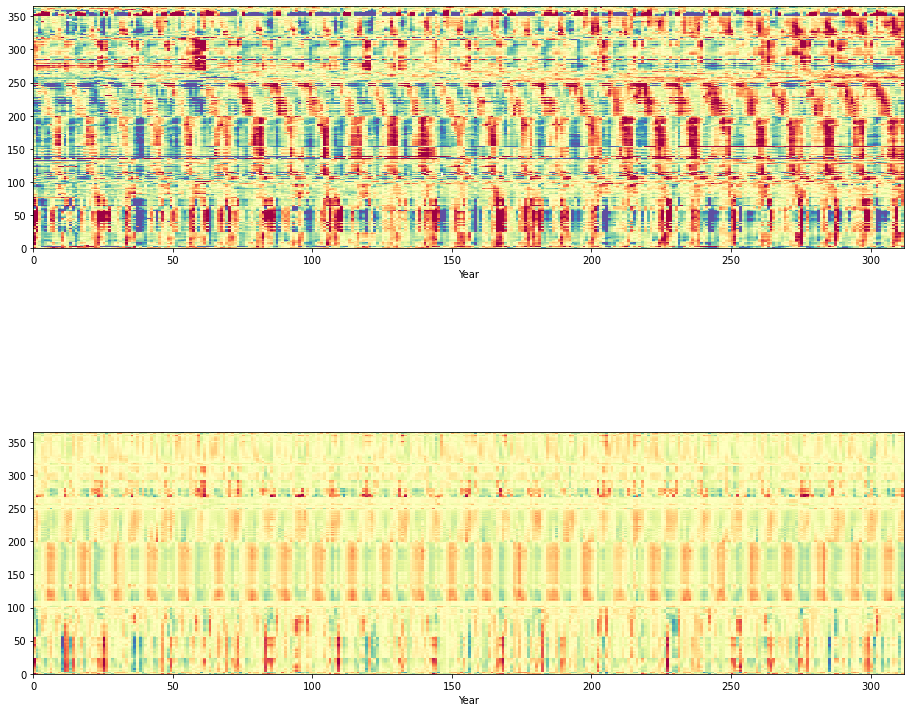

In [199]:
plt.subplots_adjust(wspace=0.1, hspace=0.05)

fig=plt.figure(figsize=(25,10), tight_layout=True)

xlabspacing=60

vmin=-20
vmax=20

ax1 = plt.subplot2grid((5,8), (0, 1), colspan=4, rowspan=2)
filled1=ax1.pcolormesh((tg_ibcorr.T),vmin=vmin,vmax=vmax,
                 cmap='Spectral_r')
plt.ylim([0,len(tgnames)])
# plt.yticks(np.arange(0.5,len(tgnames),1), tgnames,
#        rotation=0) 
# plt.xticks(np.arange(0.5,len(tg_ts_filt),xlabspacing), tg_ts_filt.index.year[np.arange(0,len(tg_ts_filt),xlabspacing)])

# plt.grid()
plt.xlabel("Year")

ax1 = plt.subplot2grid((5,8), (3, 1), colspan=4, rowspan=2)
filled1=ax1.pcolormesh((tg_ib.T),vmin=vmin,vmax=vmax,
                 cmap='Spectral_r')
plt.ylim([0,len(tgnames)])
# plt.yticks(np.arange(0.5,len(tgnames),1), tgnames,
#        rotation=0) 
# plt.xticks(np.arange(0.5,len(tg_ts_filt),xlabspacing), tg_ts_filt.index.year[np.arange(0,len(tg_ts_filt),xlabspacing)])

# plt.grid()
plt.xlabel("Year")

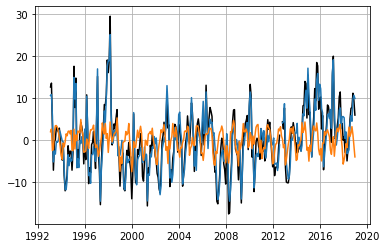

In [200]:
tgid='10'
plt.plot(tg_ts_filt[tgid].resample("M").mean(),'k')
plt.plot(tg_ibcorr[tgid].resample("M").mean())
plt.plot(tg_ib[tgid].resample("M").mean())
plt.grid()

In [202]:
tg_ib.to_pickle("./tg_ib_93_18.pkl")
tg_ibcorr.to_pickle("./tg_ts_93_18.pkl")
tgs_in.to_pickle("./real_tgs_in.pkl")